In [3]:
import os

print(os.listdir('.'))
print(os.getcwd())
os.chdir('/home/robsyc/Desktop/thesis/MB-VAE-DTI/')

['.git', 'utils', 'data', 'bmfm_sm', 'scripts', '.gitignore', 'README.md', 'ESPF', 'notebooks', 'hpc.pbs', 'requirements.txt']
/home/robsyc/Desktop/thesis/MB-VAE-DTI


---
---

# Loading, Cleaning, and Preprocessing DTI Datasets

Davis and KIBA datasets, see: https://tdcommons.ai/multi_pred_tasks/dti#davis

Datasets are downloaded from the official [`tdc`](https://pypi.org/project/PyTDC/) package. Random and cold splits are generated through their built-in functions. Additionally, a few filters are applied to remove non-drug-like molecules and targets larger than 1024 amino acids. Lastly, the y interaction value is transformed according to standard practice in the field.

Several visualization of the resulting datasets are provided to give a sense of the data distribution.

Found local copy...
Loading...
Done!
To log space...


Loading DAVIS dataset...
Exploring DAVIS dataset...


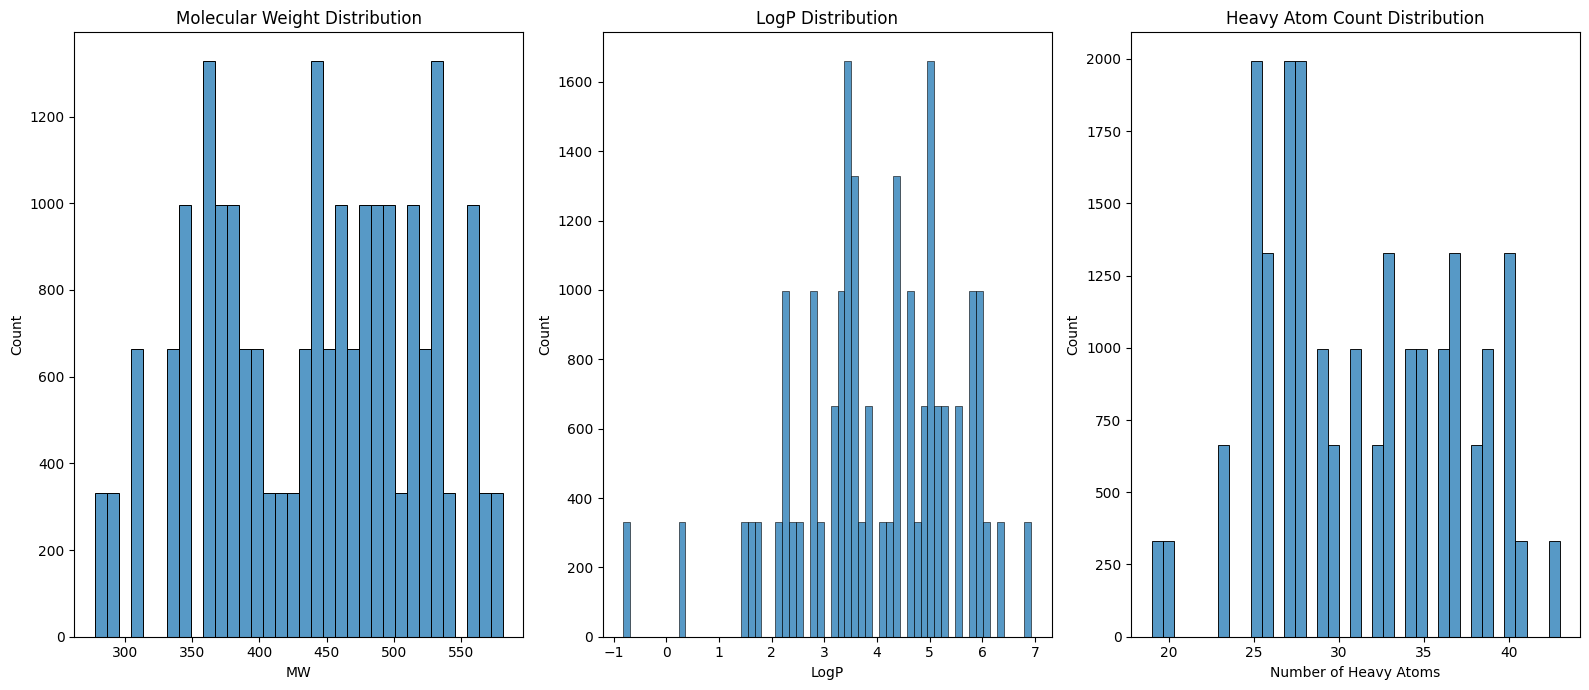

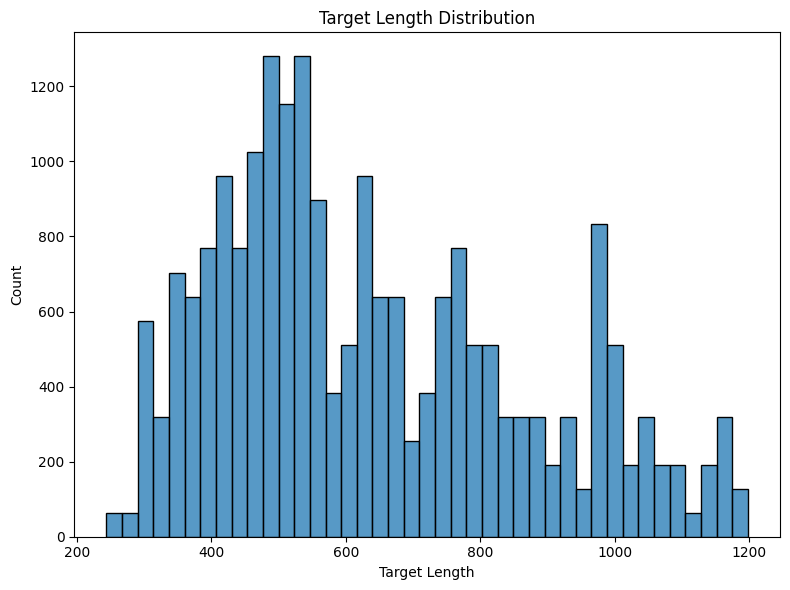

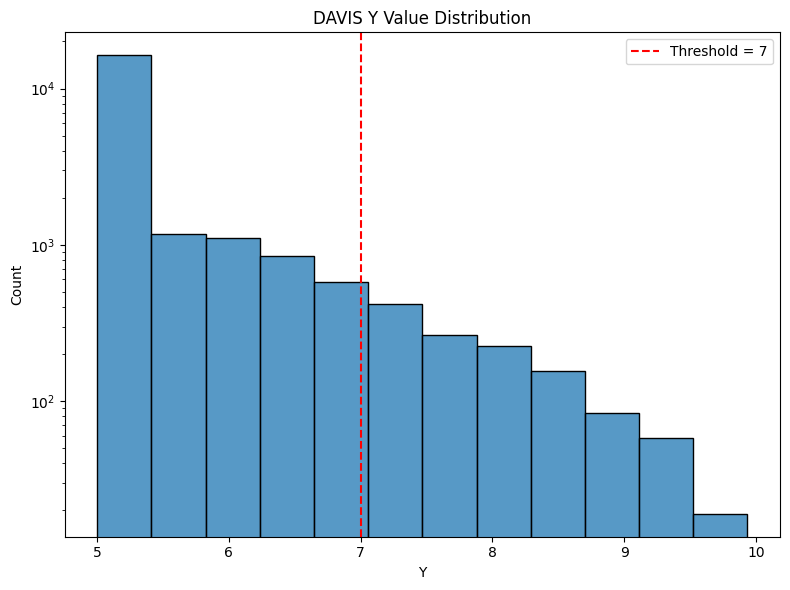

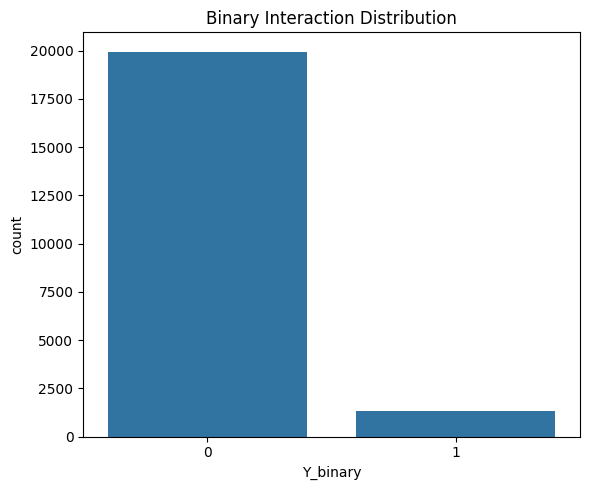

Found local copy...
Loading...


Loading KIBA dataset...


Done!


Exploring KIBA dataset...


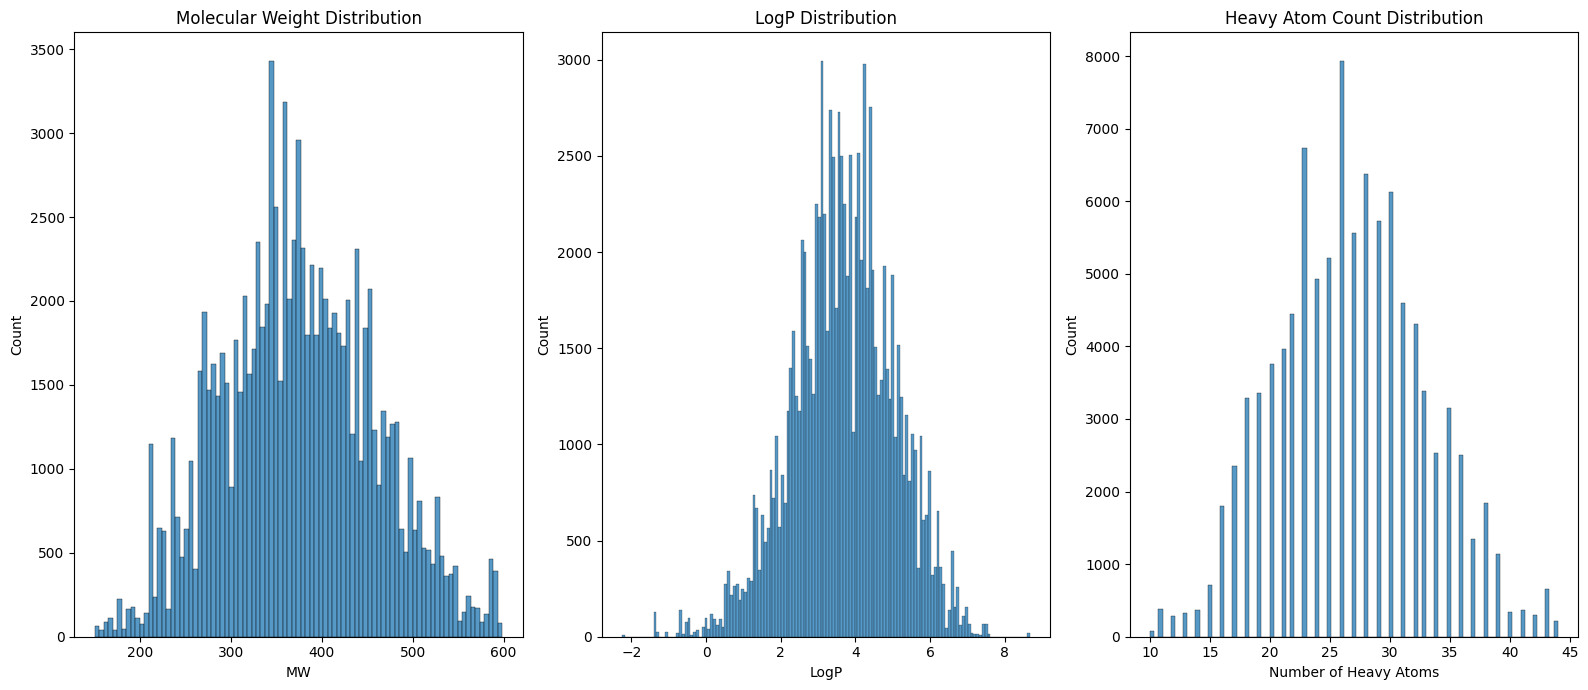

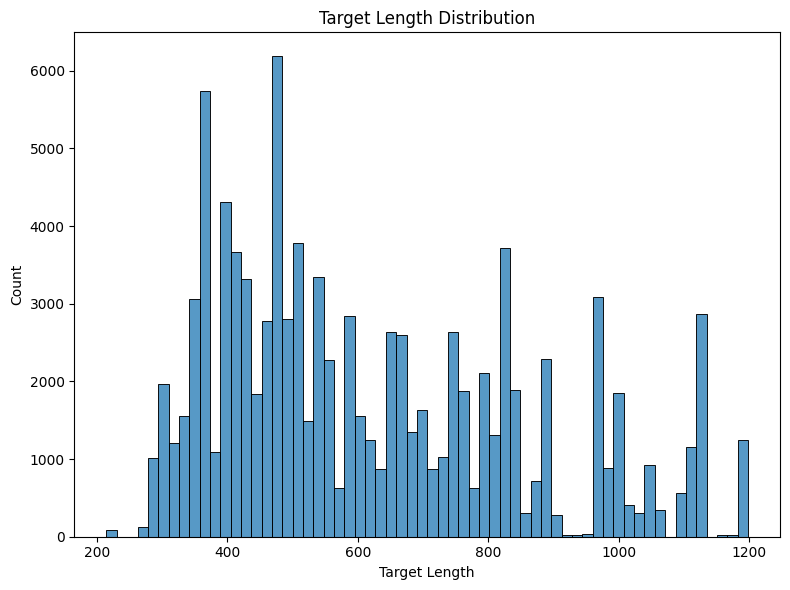

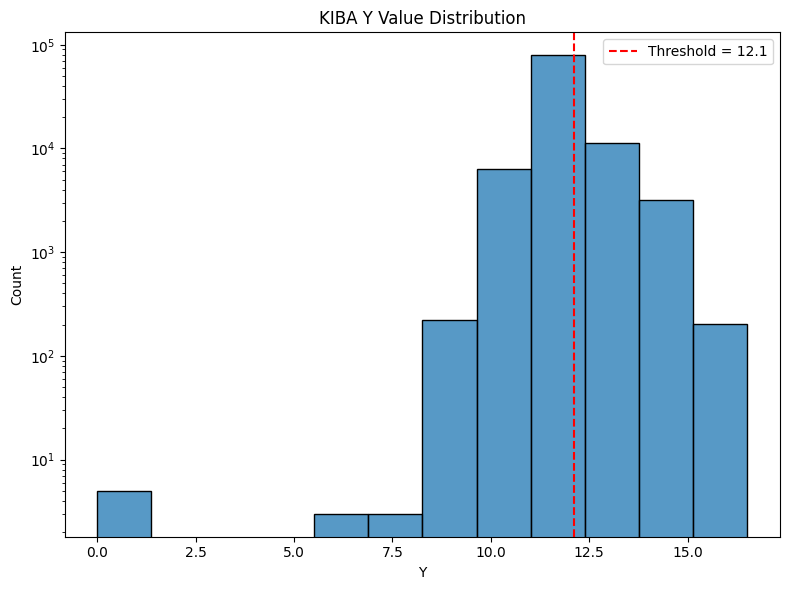

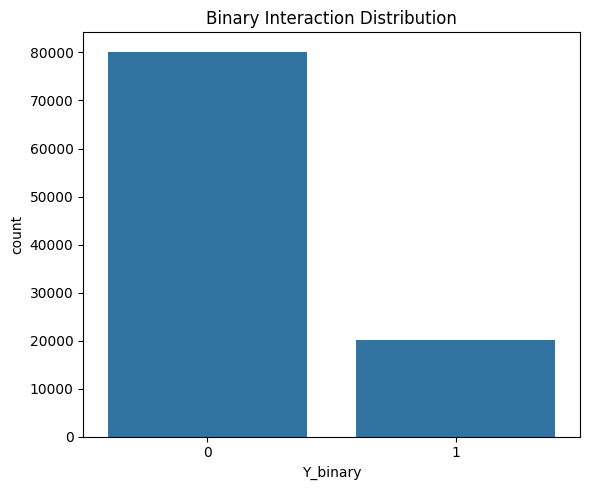

Found local copy...
Loading...


Loading BindingDB_Kd dataset...


Done!
To log space...


Exploring BindingDB_Kd dataset...


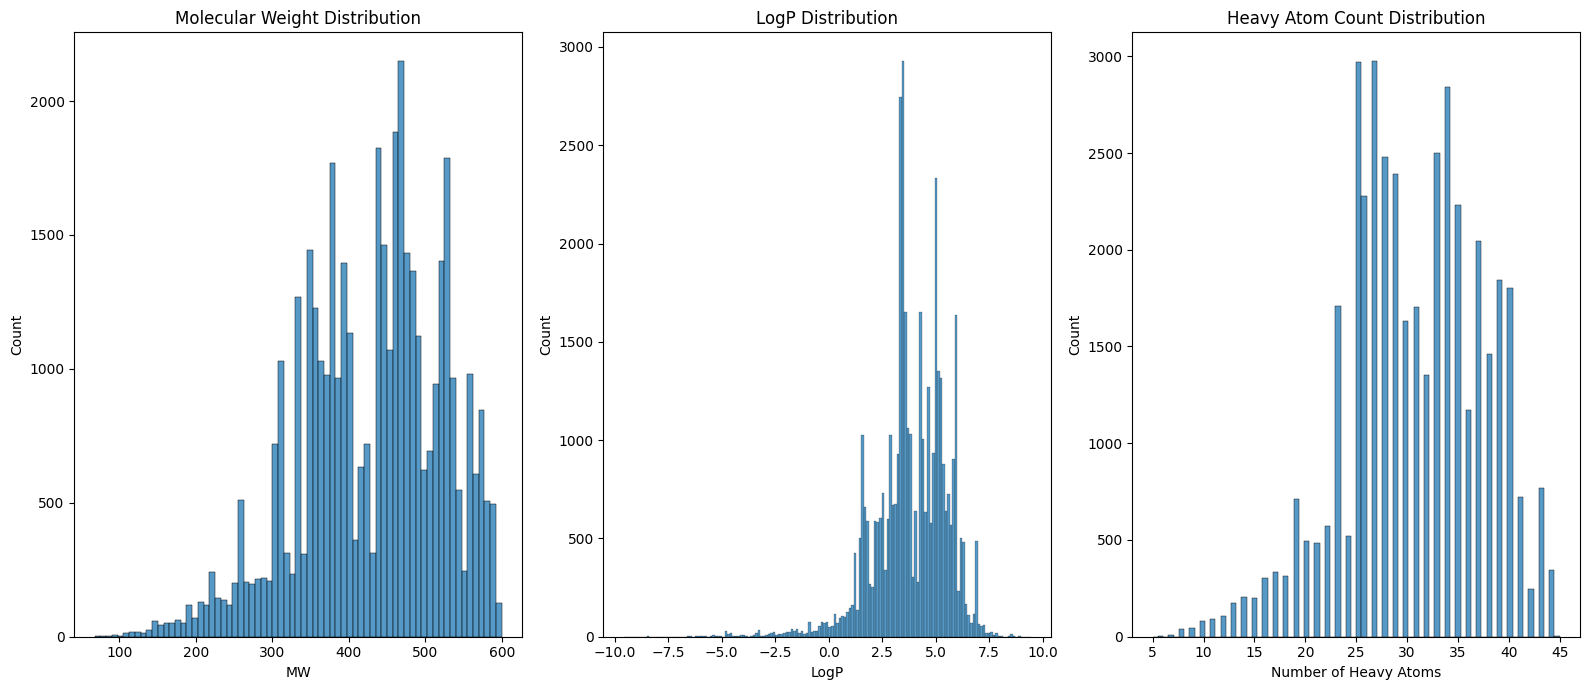

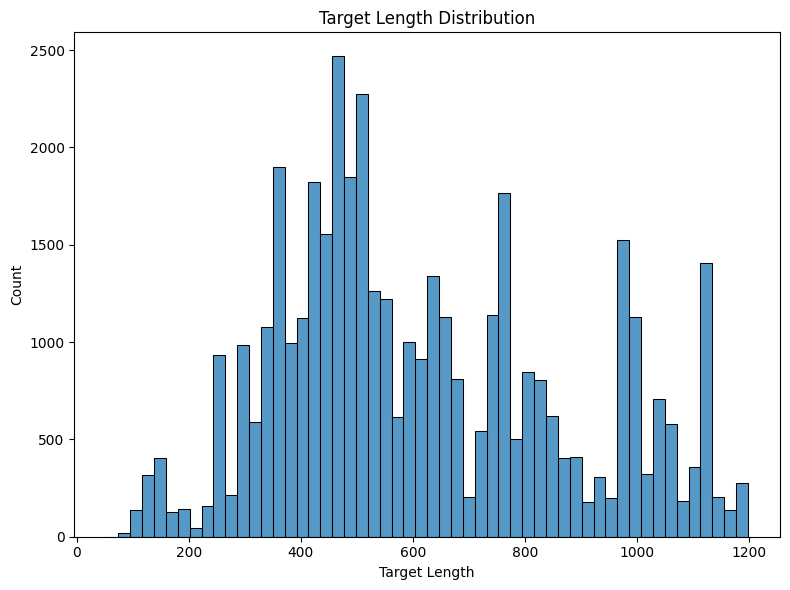

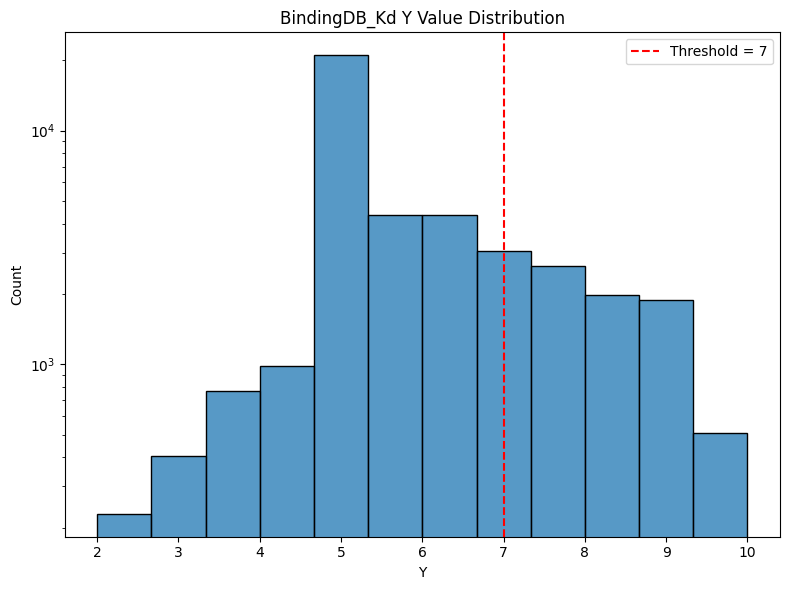

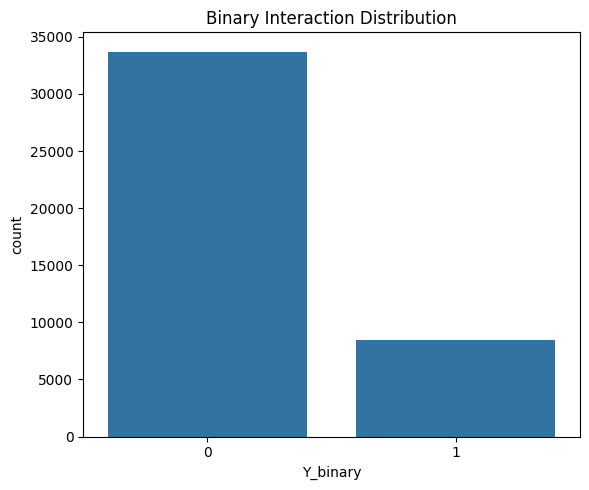

In [2]:
from utils.dataProcessing import load_df, explore_df

df_davis = load_df(
    name="DAVIS",
    use_filters=True,
    seed=42
)
explore_df(df_davis, name="DAVIS")

df_kiba = load_df(
    name="KIBA",
    use_filters=True,
    seed=42
)
explore_df(df_kiba, name="KIBA")

df_BDBKd = load_df(
    name="BindingDB_Kd",
    use_filters=True,
    seed=42
)
explore_df(df_BDBKd, name="BindingDB_Kd")

In [7]:
print(len(df_davis))
df_davis.nunique()

21248


Drug_ID          64
Drug             64
Target_ID       332
Target          332
Y               419
split_rand        3
split_cold        3
MW               64
LogP             64
HeavyAtoms       21
TargetLength    259
standardized    419
Y_binary          2
dtype: int64

In [8]:
print(len(df_kiba))
df_kiba.nunique()

100398


Drug_ID         1957
Drug            1957
Target_ID        206
Target           206
Y               2378
split_rand         3
split_cold         3
MW              1773
LogP            1851
HeavyAtoms        35
TargetLength     177
standardized    2378
Y_binary           2
dtype: int64

In [9]:
df_kiba.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100398 entries, 0 to 117656
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Drug_ID       100398 non-null  object 
 1   Drug          100398 non-null  object 
 2   Target_ID     100398 non-null  object 
 3   Target        100398 non-null  object 
 4   Y             100398 non-null  float64
 5   split_rand    100398 non-null  object 
 6   split_cold    100398 non-null  object 
 7   MW            100398 non-null  float64
 8   LogP          100398 non-null  float64
 9   HeavyAtoms    100398 non-null  int64  
 10  TargetLength  100398 non-null  int64  
 11  standardized  100398 non-null  float64
 12  Y_binary      100398 non-null  int64  
dtypes: float64(4), int64(3), object(6)
memory usage: 10.7+ MB


In [3]:
for df, name in zip([df_davis, df_kiba], ["DAVIS", "KIBA"]):
    print(f"\n{name} dataset")
    print(f"Number of drugs\t\t: {df['Drug'].nunique():,}")
    print(f"Number of targets\t: {df['Target'].nunique():,}")
    print(f"Number of interactions\t: {len(df):,}")


DAVIS dataset
Number of drugs		: 64
Number of targets	: 332
Number of interactions	: 21,248

KIBA dataset
Number of drugs		: 1,957
Number of targets	: 206
Number of interactions	: 100,398


---
---

# Creating the Datasets

We use the [`h5torch`](https://h5torch.readthedocs.io/en/latest/index.html) package for saving our datasets. This format conveniently allows for fast loading of the data and easy access in PyTorch. Furthermore, we'll enrich the DTI dataset by adding a 'DNA view' to our protein targets using the `Target_ID`. Note: these IO operations run fow a while and DAVIS's `Target_ID` key is often ambiguous. Manual curation using BLASTP was perfomed on exceptions. Resulting DNA sequences were saved in `DAVIS_target_seq_DNA.fasta`.

In [4]:
from utils.dataProcessing import generate_h5torch

generate_h5torch(df_davis, "DAVIS")
# generate_h5torch(df_kiba, "KIBA") # davis not yet fetching DNA sequences properly (wrong target ID?)

In [6]:
import h5torch

file = h5torch.File("data/dataset/DAVIS.h5t", "r")
print(file["central/indices"][:].shape)    # (2, 21248)
print(file["central/indices"][:][0].max()) # 0 - 63
print(file["0"]["Drug_ID"][:].shape)       # (63,)
print(file["central/indices"][:][1].max()) # 331
print(file["1"]["Target_ID"][:].shape)     # (331,)

print(len(file["0"]["Drug_SMILES"][:])) # 63
print(len(df_davis["Drug"].unique())) # 64

(2, 21248)
63
(64,)
331
(332,)
64
64


In [7]:
# Example use
import h5torch

davis_train_dataset = h5torch.Dataset(
    "./data/dataset/DAVIS.h5t",
    sampling="coo",
    subset=("unstructured/split_rand", "train"),
    in_memory=True,
)

len(davis_train_dataset), davis_train_dataset[100]

(14855,
 {'central': 4.9999957,
  '0/Drug_ID': '11314340',
  '0/Drug_SMILES': 'Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccccc4)c3)cc12',
  '1/Target_ID': 'JNK3',
  '1/Target_seq': 'MSLHFLYYCSEPTLDVKIAFCQGFDKQVDVSYIAKHYNMSKSKVDNQFYSVEVGDSTFTVLKRYQNLKPIGSGAQGIVCAAYDAVLDRNVAIKKLSRPFQNQTHAKRAYRELVLMKCVNHKNIISLLNVFTPQKTLEEFQDVYLVMELMDANLCQVIQMELDHERMSYLLYQMLCGIKHLHSAGIIHRDLKPSNIVVKSDCTLKILDFGLARTAGTSFMMTPYVVTRYYRAPEVILGMGYKENVDIWSVGCIMGEMVRHKILFPGRDYIDQWNKVIEQLGTPCPEFMKKLQPTVRNYVENRPKYAGLTFPKLFPDSLFPADSEHNKLKASQARDLLSKMLVIDPAKRISVDDALQHPYINVWYDPAEVEAPPPQIYDKQLDEREHTIEEWKELIYKEVMNSEEKTKNGVVKGQPSPSGAAVNSSESLPPSSSVNDISSMSTDQTLASDTDSSLEASAGPLGCCR',
  '1/Target_seq_DNA': 'ATGAGCCTCCATTTCTTATACTACTGCAGTGAACCAACATTGGATGTGAAAATTGCCTTTTGTCAGGGATTCGATAAACAAGTGGATGTGTCATATATTGCCAAACATTACAACATGAGCAAAAGCAAAGTTGACAACCAGTTCTACAGTGTGGAAGTGGGAGACTCAACCTTCACAGTTCTCAAGCGCTACCAGAATCTAAAGCCTATTGGCTCTGGGGCTCAGGGCATAGTTTGTGCCGCGTATGATGCTGTCCTTGACAGAAATGTGGCCATTAAGAAGCTCAGCAGACCCTTTCAGAACCAAACACATGCCAAGAGAGCGTACCGGGAGCTGGTC

In [60]:
import torch
torch.set_printoptions(precision=20)

# note that the items must be decoded from bytes with e.g. `item.decode('utf-8')`
davis_train_dataloader = torch.utils.data.DataLoader(davis_train_dataset, batch_size=4, shuffle=True)
batch = next(iter(davis_train_dataloader))
batch

{'central': tensor([4.99999570846557617188, 4.99999570846557617188, 4.99999570846557617188,
         4.99999570846557617188]),
 '0/Drug_ID': ['10113978', '9926791', '216239', '151194'],
 '0/Drug_SMILES': ['Cc1ccc(Nc2nccc(N(C)c3ccc4c(C)n(C)nc4c3)n2)cc1S(N)(=O)=O',
  'CC1CCN(C(=O)CC#N)CC1N(C)c1ncnc2[nH]ccc12',
  'CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)c3)cc2)ccn1',
  'Clc1ccc(Nc2nnc(Cc3ccncc3)c3ccccc23)cc1'],
 '1/Target_ID': ['MST2', 'BMPR1B', 'BTK', 'DCAMKL3'],
 '1/Target_seq': ['MEQPPAPKSKLKKLSEDSLTKQPEEVFDVLEKLGEGSYGSVFKAIHKESGQVVAIKQVPVESDLQEIIKEISIMQQCDSPYVVKYYGSYFKNTDLWIVMEYCGAGSVSDIIRLRNKTLIEDEIATILKSTLKGLEYLHFMRKIHRDIKAGNILLNTEGHAKLADFGVAGQLTDTMAKRNTVIGTPFWMAPEVIQEIGYNCVADIWSLGITSIEMAEGKPPYADIHPMRAIFMIPTNPPPTFRKPELWSDDFTDFVKKCLVKNPEQRATATQLLQHPFIKNAKPVSILRDLITEAMEIKAKRHEEQQRELEEEEENSDEDELDSHTMVKTSVESVGTMRATSTMSEGAQTMIEHNSTMLESDLGTMVINSEDEEEEDGTMKRNATSPQVQRPSFMDYFDKQDFKNKSHENCNQNMHEPFPMSKNVFPDNWKVPQDGDFDFLKNLSLEELQMRLKALDPMMEREIEELRQRYTAKRQPILDAMDAKKRRQQNF',
  'MLLRSAGKLNVG

In [63]:
df_davis[df_davis["Drug_ID"] == 10113978].iloc[0]["Drug"]

'Cc1ccc(Nc2nccc(N(C)c3ccc4c(C)n(C)nc4c3)n2)cc1S(N)(=O)=O'

---
---

# Embeddings and Fingerprints

Because we will (for now) not be fine-tuning the foundation models used, we pre-compute the embeddings associated with the drug (SMILES strings) and targets (amino acid sequence) data. These embeddings are then saved in the same `h5t` file as the datasets.

For each entitiy (drug and target), we generate a fingerprint and three embeddings using different DL models - emphasising their various 'views'. The following models were used:

- Drug molecules
  - Molecule **fingerprints** with [`RDKIT's GetFingerprint method`](https://greglandrum.github.io/rdkit-blog/posts/2023-01-18-fingerprint-generator-tutorial.html)
  - Graph, Image and Text embedding using [`ibm/biomed.sm.mv-te-84m`](https://huggingface.co/ibm/biomed.sm.mv-te-84m)
- Target proteins
  - Protein **fingerprints** with [`ESPF adapted from DeepPurpose`](https://github.com/kexinhuang12345/DeepPurpose)
  - Structure-infused embeddings with [`Rostlab/ProstT5`](https://huggingface.co/Rostlab/ProstT5)
  - Protein sequence embeddings with [`facebook/esm2_t33_650M_UR50D`](https://huggingface.co/facebook/esm2_t36_3B_UR50D)
  - DNA sequence embeddings with multispecies [`InstaDeepAI/nucleotide-transformer`](https://huggingface.co/InstaDeepAI/nucleotide-transformer-v2-500m-multi-species)

# Generating fingerprints

In [23]:
from utils.preEmbedding import get_drug_fingerprint

SMILES = 'CC(C)N1NC(=C2C=c3cc(O)ccc3=N2)c2c(N)ncnc21'
fp = get_drug_fingerprint(SMILES)
fp.shape, sum(fp), fp

((2048,), 47, array([0, 1, 0, ..., 0, 0, 0]))

In [24]:
from utils.preEmbedding import get_target_fingerprint

s = "MGSNKSKPKDASQRRRSLEPAEQAFLEDYFTSTEPQYQPGENL"
v = get_target_fingerprint(s)
v.shape, sum(v), v

((4170,), 20.0, array([0., 0., 0., ..., 0., 0., 0.]))

## Generating embeddings

In [17]:
from utils.preEmbedding import BiomedMultiViewMoleculeEncoder

encoder = BiomedMultiViewMoleculeEncoder(
    inference_mode=True,
    huggingface=False
)

SMILES_list = ['CCC1C(=O)N(C)c2cnc(Nc3ccc(C(=O)NC4CCN(C)CC4)cc3OC)nc2N1C1CCCC1']
graph_emb, image_emb, text_emb = encoder(SMILES_list)
graph_emb.shape, image_emb.shape, text_emb.shape

2025-01-06 22:36:03,856 - root - INFO - pop-os:126314761862912:0:0 - BioMed Multi-view embedding model
2025-01-06 22:36:03,856 - root - INFO - pop-os:126314761862912:0:0 - dim_list [512, 512, 768] of Graph2dModel, ImageModel, TextModel
2025-01-06 22:36:03,870 - root - INFO - pop-os:126314761862912:0:0 - Loading checkpoint from provided path ./data/model_saves/Biomed-smmv/biomed-smmv-base.pth
2025-01-06 22:36:04,027 - root - INFO - pop-os:126314761862912:0:0 - Loading pretrain checkpoint for SmallMoleculeMultiView Model - _IncompatibleKeys(missing_keys=['aggregator.projections.0.weight', 'aggregator.projections.0.bias', 'aggregator.projections.1.weight', 'aggregator.projections.1.bias', 'aggregator.projections.2.weight', 'aggregator.projections.2.bias', 'aggregator.w_before_mean.0.weight', 'aggregator.w_before_mean.0.bias', 'aggregator.w_before_mean.2.weight', 'aggregator.down_project.weight', 'aggregator.down_project.bias', 'aggregator.shared_task_head.0.weight', 'aggregator.shared_tas

(torch.Size([1, 512]), torch.Size([1, 512]), torch.Size([1, 768]))

In [22]:
text_emb[0][:7]

tensor([ 1.2271,  0.1851,  0.9304, -0.3675,  0.0871, -0.4971,  0.6887],
       grad_fn=<SliceBackward0>)

In [11]:
from utils.preEmbedding import T5ProstTargetEncoder
import torch

encoder = T5ProstTargetEncoder(
    huggingface=False
)

target_list = ['MGSNKSKPKDASQRRRSLEPAEQAFLEDYFTSTEPQYQPGENL', 'MGSNKSKPKDASQRRRSLEPAEQAFLEDYFTSTEPQYQPGENL']
target_emb = encoder(target_list)
target_emb.shape

torch.Size([2, 1024])

In [ ]:
from utils.preEmbedding import ESMTargetEncoder

encoder = ESMTargetEncoder()

target_list = ['MGSNKSKPKDASQRRRSLEPAEQAFLEDYFTSTEPQYQPGENL', 'MGSNKSKPKDASQRRRSLEPAEQAFLEDYFTSTEPQYQPGENL']
target_emb = encoder(target_list)
target_emb.shape

The pre-trained amino acid / DNA transformer models are quite compute-intensive. See the `./scripts` directory to run them from a terminal and add the generated embeddings to the `h5torch` file (13.2 MB). 

In [16]:
import h5torch
import random

f = h5torch.File("./data/dataset/DAVIS.h5t", "r")
dataset = h5torch.Dataset("./data/dataset/DAVIS.h5t", sampling="coo", subset=("unstructured/split_cold", "train"))

print(f"Number of drug-target pairs: {len(dataset):,}")
print("Number of drugs: ", len(f["0/Drug_ID"][:]))
print("Number of targets: ", len(f["1/Target_ID"][:]))

i = random.randint(0, len(dataset))
# i = 0

example = dataset[i]
for key in example.keys():
    print('\n', key, str(example[key])[:100])

    try:
        print(len(example[key]), example[key].shape)
    except:
        print(example[key].shape)
    

Number of drug-target pairs: 15,272
Number of drugs:  64
Number of targets:  332

 central 6.4558077
()

 0/Drug_ID 11364421
8 ()

 0/Drug_SMILES CCC1C(=O)N(C)c2cnc(Nc3ccc(C(=O)NC4CCN(C)CC4)cc3OC)nc2N1C1CCCC1
62 ()

 0/Drug_emb_graph [ 3.08044329e-02  5.59370816e-02 -6.88896999e-02 -2.30330303e-01
 -6.09384477e-02  2.12611258e-03  8
512 (512,)

 0/Drug_emb_image [0.85435    0.41389295 0.85740095 0.8104933  0.5918401  0.6149174
 0.7608986  0.7226158  0.82811207 
512 (512,)

 0/Drug_emb_text [ 1.22707009e+00  1.85106665e-01  9.30367351e-01 -3.67540896e-01
  8.70533437e-02 -4.97057199e-01  6
768 (768,)

 0/Drug_fp [0. 0. 0. ... 1. 0. 0.]
2048 (2048,)

 1/Target_ID PRKD3
5 ()

 1/Target_emb_DNA [ 0.05492428  0.09005232 -0.1376576  ... -0.06544273  0.42155474
  0.01248967]
1024 (1024,)

 1/Target_emb_ESM [ 0.02554647 -0.06461771 -0.02859839 ... -0.19572212  0.07018673
  0.1377108 ]
1280 (1280,)

 1/Target_emb_T5 [-0.0328064   0.01802063 -0.03060913 ...  0.00216293 -0.02622986
 -0.0141983 ]
